# Sentinel Data Generator - Log Analysis

This notebook analyzes the demo security data generated by the Sentinel Data Generator project.
It runs on the **Microsoft Sentinel Data Lake** using the `MicrosoftSentinelProvider` class
with Apache Spark and `matplotlib` for visualizations.

**Tables Analyzed:**
- `SecurityEventDemo_CL` — Windows Security Events
- `CommonSecurityLog` — CEF/Syslog from security appliances
- `SigninLogDemo_CL` — Azure AD/Entra ID Sign-in Logs
- `SyslogDemo_CL` — Linux Syslog Events

**Requirements:**
- Microsoft Sentinel extension for VS Code
- Sentinel Data Lake onboarded
- Select a Microsoft Sentinel runtime (Small/Medium/Large) when prompted

> Based on [Microsoft Sentinel Data Lake notebook documentation](https://learn.microsoft.com/en-us/azure/sentinel/datalake/notebooks)

## 1. Setup and Connection

Initialize the `MicrosoftSentinelProvider` using the Spark session provided by the Sentinel runtime.

In [28]:
import matplotlib.pyplot as plt
from sentinel_lake.providers import MicrosoftSentinelProvider
from pyspark.sql.functions import (
    col, count, countDistinct, when, desc, asc, lit, lower, sum as spark_sum
)

data_provider = MicrosoftSentinelProvider(spark)
print("MicrosoftSentinelProvider initialized")

StatementMeta(MSGMedium, 3, 29, Finished, Available, Finished)

MicrosoftSentinelProvider initialized


In [29]:
# Replace with your workspace name
WORKSPACE_NAME = "SDLWS"

# List available databases to verify connectivity
databases = data_provider.list_databases()
print("Available databases/workspaces:")
for db in databases:
    print(f"  - {db}")

StatementMeta(MSGMedium, 3, 7, Finished, Available, Finished)

Available databases/workspaces:
  - System Tables
  - SDLWS


StatementMeta(MSGMedium, 3, 30, Finished, Available, Finished)

Available databases/workspaces:
  - System Tables
  - SDLWS


## 2. Load All Tables

Read the four demo tables from the data lake into Spark DataFrames.

In [30]:
# Load all four tables
df_security_events = data_provider.read_table("SecurityEventDemo_CL", WORKSPACE_NAME)
df_common_security = data_provider.read_table("CommonSecurityLog", WORKSPACE_NAME)
df_signin_logs = data_provider.read_table("SigninLogDemo_CL", WORKSPACE_NAME)
df_syslog = data_provider.read_table("SyslogDemo_CL", WORKSPACE_NAME)

# Get row counts
counts = {
    "SecurityEventDemo_CL": df_security_events.count(),
    "CommonSecurityLog": df_common_security.count(),
    "SigninLogDemo_CL": df_signin_logs.count(),
    "SyslogDemo_CL": df_syslog.count()
}

total = sum(counts.values())
print(f"Total events loaded: {total:,}")
for table, cnt in counts.items():
    print(f"  {table}: {cnt:,}")

StatementMeta(MSGMedium, 3, 31, Finished, Available, Finished)

{"Level": "INFO", "TraceId": "c73d69e9-4bae-41ac-be0a-5217ab37d8f5", "Message": "Loading table: SecurityEventDemo_CL"}
{"Level": "INFO", "TraceId": "c73d69e9-4bae-41ac-be0a-5217ab37d8f5", "Message": "Successfully loaded table SecurityEventDemo_CL"}
{"Level": "INFO", "TraceId": "c73d69e9-4bae-41ac-be0a-5217ab37d8f5", "Message": "Loading table: CommonSecurityLog"}
{"Level": "INFO", "TraceId": "c73d69e9-4bae-41ac-be0a-5217ab37d8f5", "Message": "Successfully loaded table CommonSecurityLog"}
{"Level": "INFO", "TraceId": "c73d69e9-4bae-41ac-be0a-5217ab37d8f5", "Message": "Loading table: SigninLogDemo_CL"}
{"Level": "INFO", "TraceId": "c73d69e9-4bae-41ac-be0a-5217ab37d8f5", "Message": "Successfully loaded table SigninLogDemo_CL"}
{"Level": "INFO", "TraceId": "c73d69e9-4bae-41ac-be0a-5217ab37d8f5", "Message": "Loading table: SyslogDemo_CL"}
{"Level": "INFO", "TraceId": "c73d69e9-4bae-41ac-be0a-5217ab37d8f5", "Message": "Successfully loaded table SyslogDemo_CL"}
Total events loaded: 5,101
  Sec

StatementMeta(MSGMedium, 2, 10, Finished, Available, Finished)

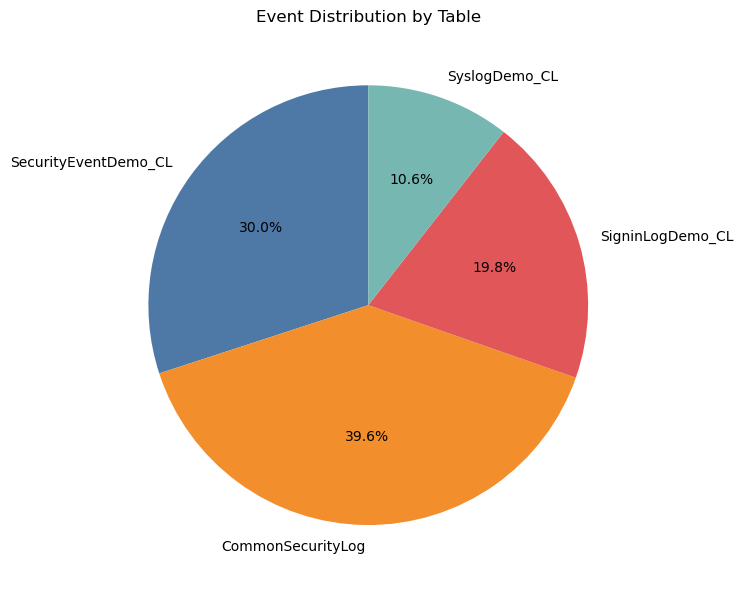

StatementMeta(MSGMedium, 3, 9, Finished, Available, Finished)

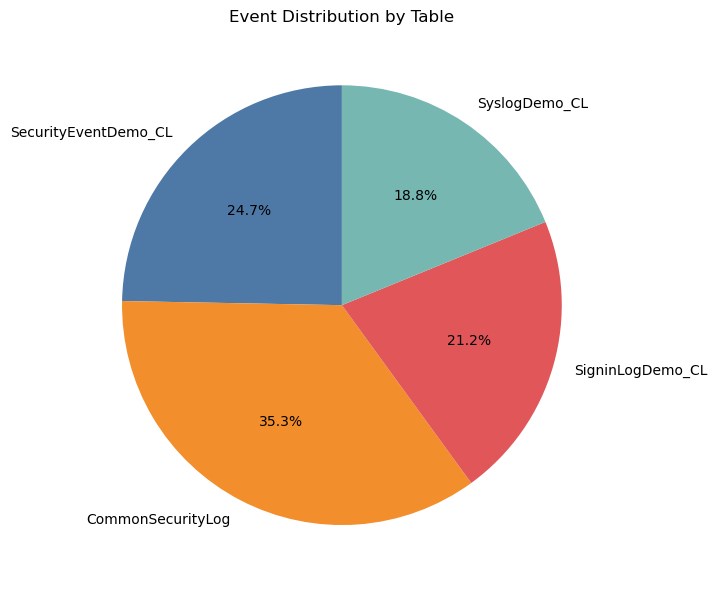

StatementMeta(MSGMedium, 3, 32, Finished, Available, Finished)

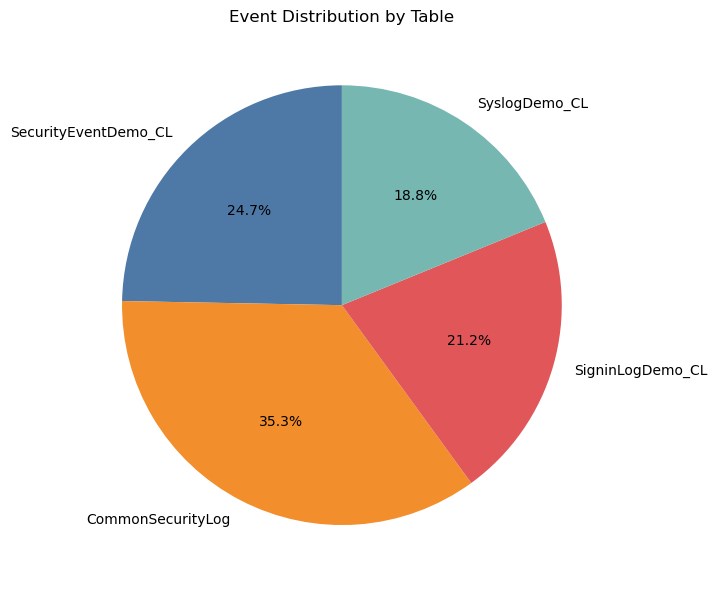

In [31]:
# Visualize event distribution across tables
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(
    counts.values(),
    labels=counts.keys(),
    autopct="%1.1f%%",
    startangle=90,
    colors=["#4e79a7", "#f28e2b", "#e15759", "#76b7b2"]
)
ax.set_title("Event Distribution by Table")
plt.tight_layout()
plt.show()

## 3. SecurityEventDemo_CL Analysis

Windows Security Events including failed/successful logons, privilege escalation, and account management.

In [32]:
# Security events by EventID
security_by_event = (
    df_security_events
    .groupBy("EventID", "Activity")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
)

security_by_event.show(truncate=False)

StatementMeta(MSGMedium, 3, 10, Finished, Available, Finished)

+-------+------------------------------------------------+-----+
|EventID|Activity                                        |Count|
+-------+------------------------------------------------+-----+
|4625   |4625 - An account failed to log on.             |711  |
|4624   |4624 - An account was successfully logged on.   |324  |
|4720   |4720 - A user account was created.              |120  |
|4672   |4672 - Special privileges assigned to new logon.|105  |
+-------+------------------------------------------------+-----+



StatementMeta(MSGMedium, 3, 33, Finished, Available, Finished)

+-------+------------------------------------------------+-----+
|EventID|Activity                                        |Count|
+-------+------------------------------------------------+-----+
|4625   |4625 - An account failed to log on.             |711  |
|4624   |4624 - An account was successfully logged on.   |324  |
|4720   |4720 - A user account was created.              |120  |
|4672   |4672 - Special privileges assigned to new logon.|105  |
+-------+------------------------------------------------+-----+



StatementMeta(MSGMedium, 2, 12, Finished, Available, Finished)

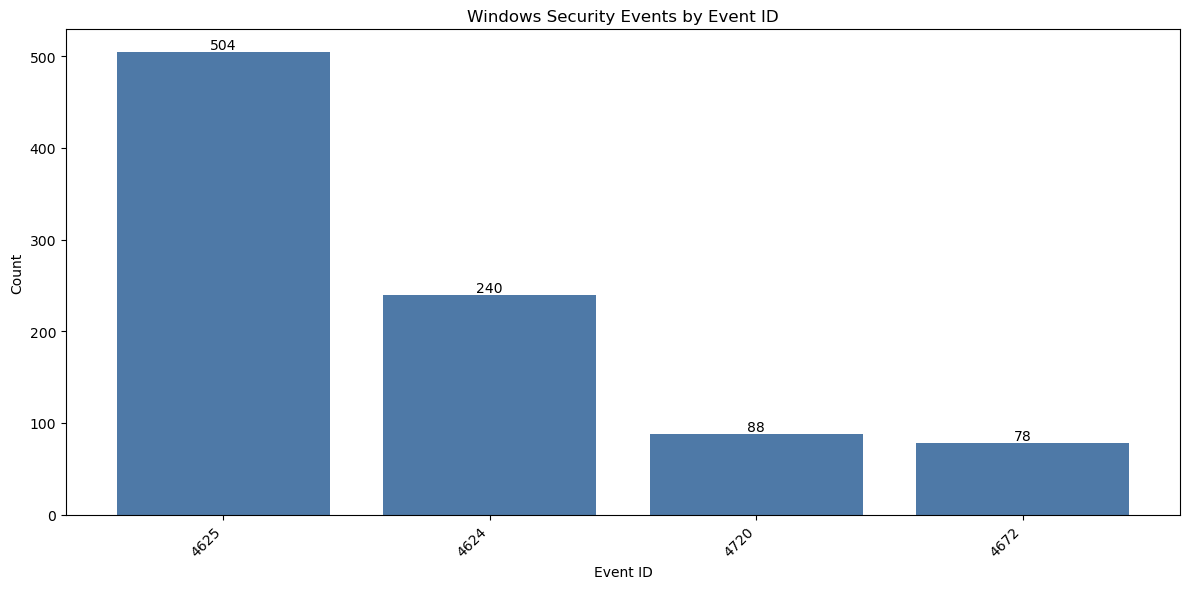

StatementMeta(MSGMedium, 3, 11, Finished, Available, Finished)

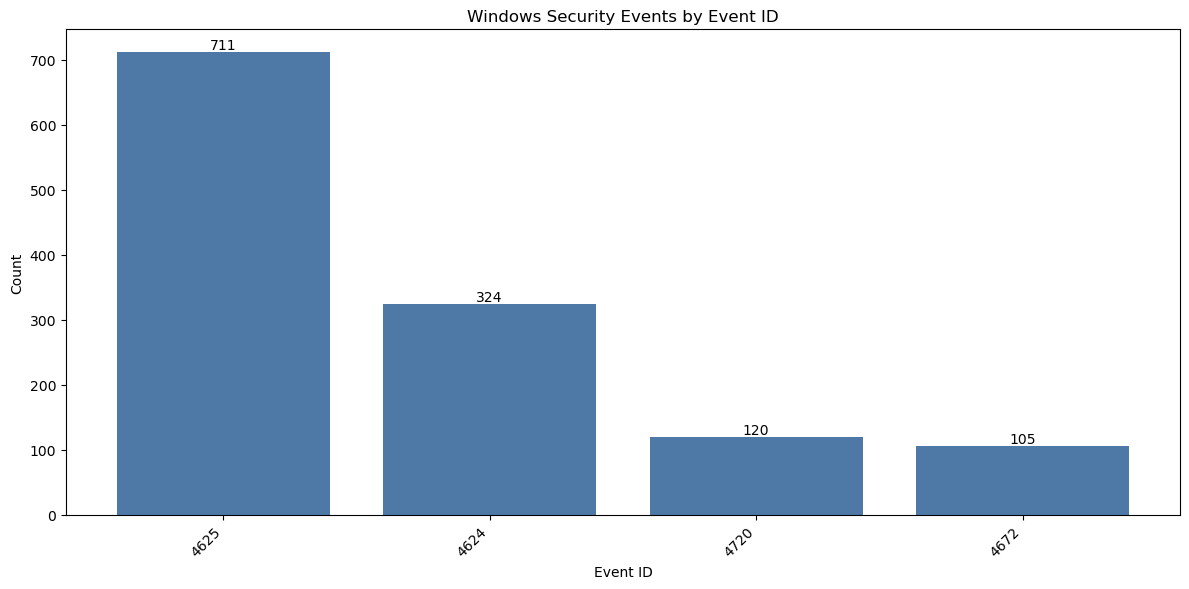

StatementMeta(MSGMedium, 3, 34, Finished, Available, Finished)

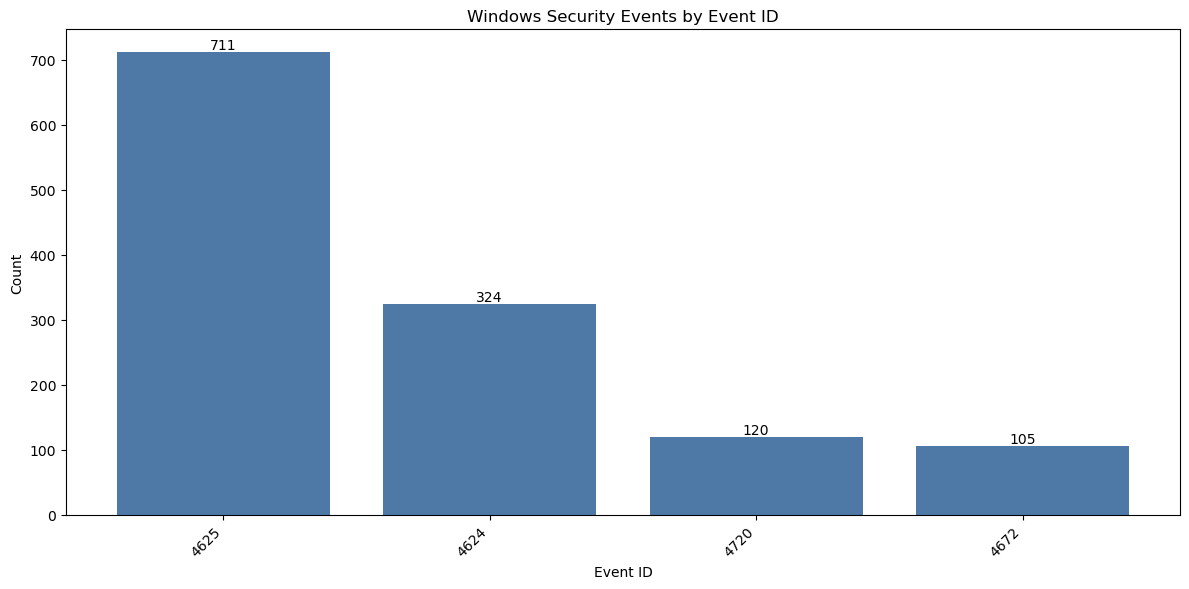

In [33]:
# Visualize security events by EventID
pd_security = security_by_event.toPandas()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(pd_security["EventID"].astype(str), pd_security["Count"], color="#4e79a7")
ax.bar_label(bars)
ax.set_xlabel("Event ID")
ax.set_ylabel("Count")
ax.set_title("Windows Security Events by Event ID")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [34]:
# Failed logins analysis — potential brute force detection (EventID 4625)
failed_logins = (
    df_security_events
    .filter(col("EventID") == 4625)
    .groupBy("IpAddress", "Account", "Computer")
    .agg(count("*").alias("FailedAttempts"))
    .filter(col("FailedAttempts") >= 5)
    .orderBy(desc("FailedAttempts"))
    .limit(20)
)

print("Potential Brute Force Sources (5+ failed logins):")
failed_logins.show(truncate=False)

StatementMeta(MSGMedium, 3, 35, Finished, Available, Finished)

Potential Brute Force Sources (5+ failed logins):
+------------+-------+----------------+--------------+
|IpAddress   |Account|Computer        |FailedAttempts|
+------------+-------+----------------+--------------+
|203.0.113.50|admin  |DC01.contoso.com|711           |
+------------+-------+----------------+--------------+



StatementMeta(MSGMedium, 3, 13, Finished, Available, Finished)

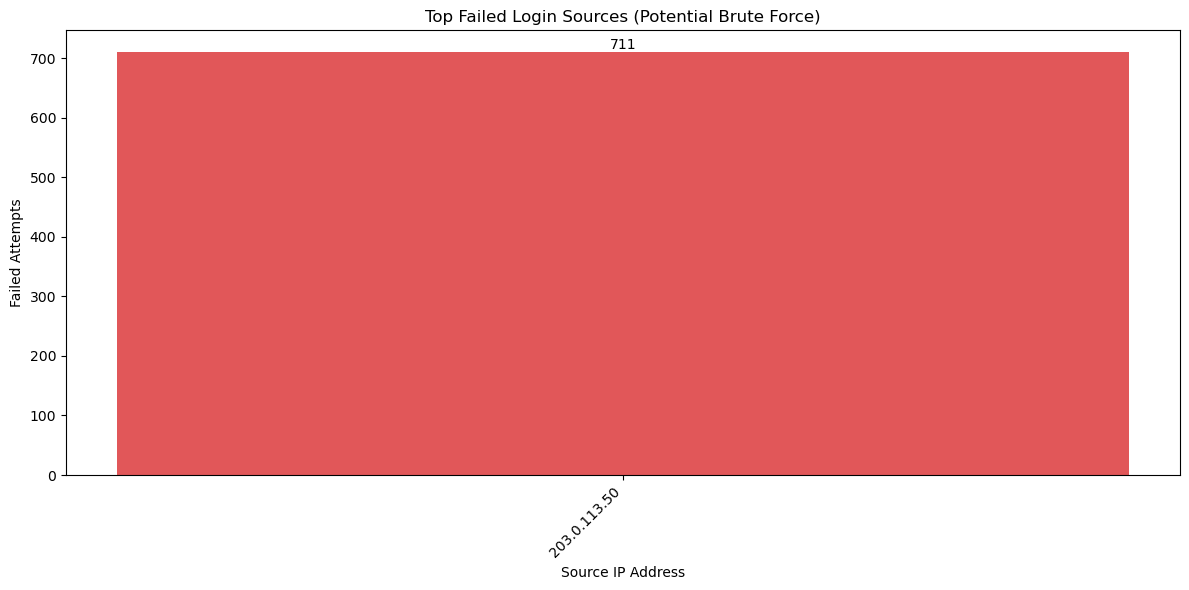

StatementMeta(MSGMedium, 3, 36, Finished, Available, Finished)

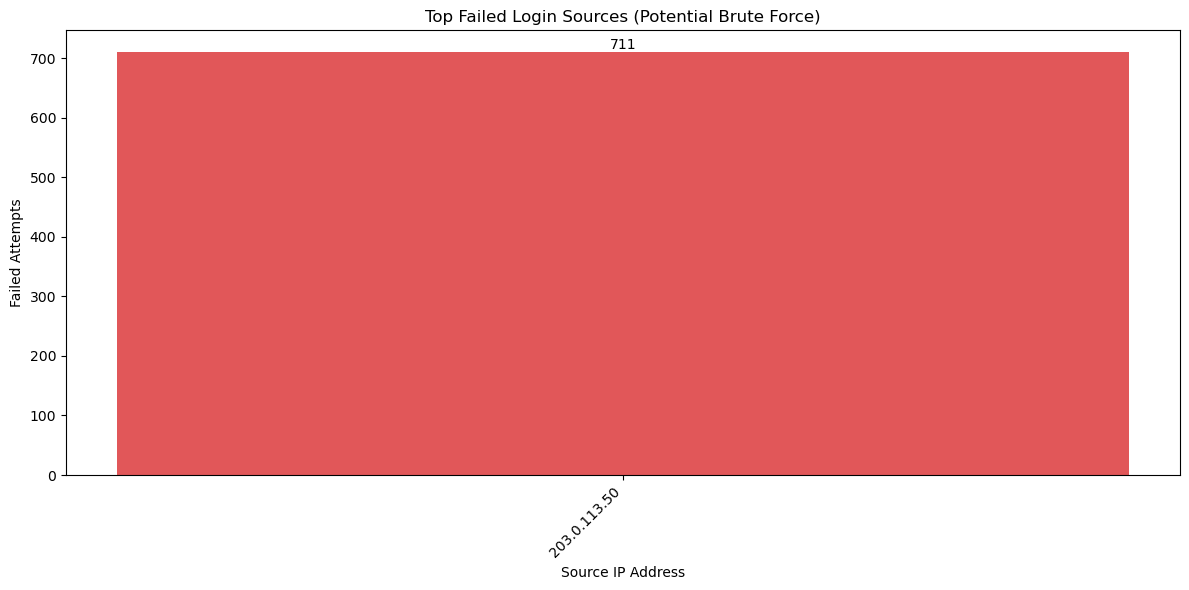

In [35]:
# Visualize top failed login sources
pd_failed = failed_logins.toPandas()

if not pd_failed.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    top10 = pd_failed.head(10)
    bars = ax.bar(top10["IpAddress"], top10["FailedAttempts"], color="#e15759")
    ax.bar_label(bars)
    ax.set_xlabel("Source IP Address")
    ax.set_ylabel("Failed Attempts")
    ax.set_title("Top Failed Login Sources (Potential Brute Force)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No brute force sources found.")

## 4. CommonSecurityLog Analysis

CEF events from security appliances including firewall, IDS, and threat intelligence.

In [36]:
# Events by vendor and event class
cef_by_vendor = (
    df_common_security
    .groupBy("DeviceVendor", "DeviceEventClassID")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
    .limit(20)
)

cef_by_vendor.show(truncate=False)

StatementMeta(MSGMedium, 2, 15, Finished, Available, Finished)

+------------------+------------------+-----+
|DeviceVendor      |DeviceEventClassID|Count|
+------------------+------------------+-----+
|Palo Alto Networks|intrusion:detected|171  |
|Palo Alto Networks|threat:match      |152  |
|Palo Alto Networks|traffic:allow     |125  |
|Palo Alto Networks|malware:detected  |115  |
|Palo Alto Networks|traffic:deny      |113  |
|Palo Alto Networks|web:access        |106  |
|Palo Alto Networks|vpn:connection    |100  |
|Check Point       |intrusion:detected|64   |
|Cisco             |intrusion:detected|48   |
|Fortinet          |intrusion:detected|44   |
|Zscaler           |threat:match      |36   |
|Cisco             |threat:match      |35   |
|Zscaler           |intrusion:detected|34   |
|Check Point       |threat:match      |31   |
|Fortinet          |threat:match      |26   |
|Test              |test              |1    |
+------------------+------------------+-----+



StatementMeta(MSGMedium, 3, 14, Finished, Available, Finished)

+------------------+------------------+-----+
|DeviceVendor      |DeviceEventClassID|Count|
+------------------+------------------+-----+
|Palo Alto Networks|intrusion:detected|256  |
|Palo Alto Networks|threat:match      |225  |
|Palo Alto Networks|traffic:allow     |194  |
|Palo Alto Networks|malware:detected  |167  |
|Palo Alto Networks|web:access        |163  |
|Palo Alto Networks|traffic:deny      |160  |
|Palo Alto Networks|vpn:connection    |159  |
|Check Point       |intrusion:detected|88   |
|Cisco             |intrusion:detected|72   |
|Fortinet          |intrusion:detected|67   |
|Zscaler           |intrusion:detected|55   |
|Zscaler           |threat:match      |51   |
|Check Point       |threat:match      |48   |
|Cisco             |threat:match      |48   |
|Fortinet          |threat:match      |47   |
|Test              |test              |1    |
+------------------+------------------+-----+



StatementMeta(MSGMedium, 3, 37, Finished, Available, Finished)

+------------------+------------------+-----+
|DeviceVendor      |DeviceEventClassID|Count|
+------------------+------------------+-----+
|Palo Alto Networks|intrusion:detected|256  |
|Palo Alto Networks|threat:match      |225  |
|Palo Alto Networks|traffic:allow     |194  |
|Palo Alto Networks|malware:detected  |167  |
|Palo Alto Networks|web:access        |163  |
|Palo Alto Networks|traffic:deny      |160  |
|Palo Alto Networks|vpn:connection    |159  |
|Check Point       |intrusion:detected|88   |
|Cisco             |intrusion:detected|72   |
|Fortinet          |intrusion:detected|67   |
|Zscaler           |intrusion:detected|55   |
|Zscaler           |threat:match      |51   |
|Check Point       |threat:match      |48   |
|Cisco             |threat:match      |48   |
|Fortinet          |threat:match      |47   |
|Test              |test              |1    |
+------------------+------------------+-----+



StatementMeta(MSGMedium, 3, 38, Finished, Available, Finished)

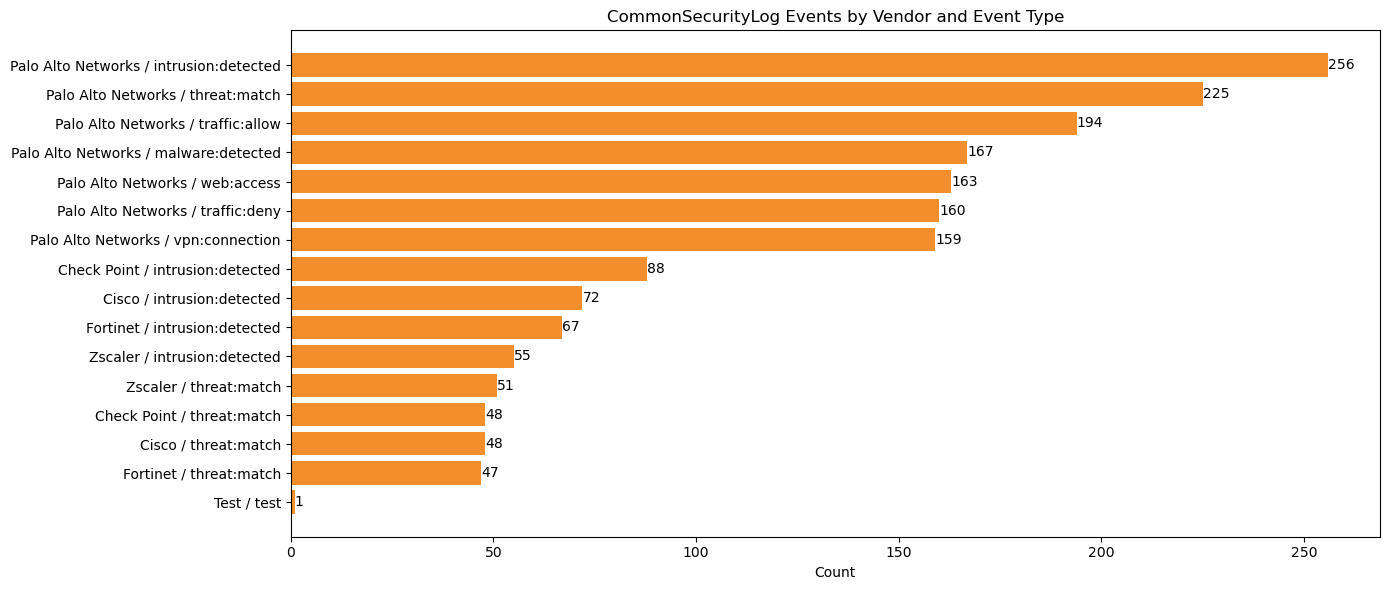

In [37]:
# Visualize CEF events by vendor
pd_cef = cef_by_vendor.toPandas()

fig, ax = plt.subplots(figsize=(14, 6))
labels = pd_cef["DeviceVendor"] + " / " + pd_cef["DeviceEventClassID"]
bars = ax.barh(labels, pd_cef["Count"], color="#f28e2b")
ax.bar_label(bars)
ax.set_xlabel("Count")
ax.set_title("CommonSecurityLog Events by Vendor and Event Type")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [38]:
# Threat intelligence and intrusion detections
threat_event_types = ["threat:match", "intrusion:detected", "malware:detected"]

threats = (
    df_common_security
    .filter(col("DeviceEventClassID").isin(threat_event_types))
    .groupBy("DeviceVendor", "DeviceEventClassID", "SourceIP")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
    .limit(15)
)

print("Security Threats Detected:")
threats.show(truncate=False)

StatementMeta(MSGMedium, 2, 17, Finished, Available, Finished)

Security Threats Detected:
+------------------+------------------+-------------+-----+
|DeviceVendor      |DeviceEventClassID|SourceIP     |Count|
+------------------+------------------+-------------+-----+
|Palo Alto Networks|intrusion:detected|198.51.100.11|28   |
|Palo Alto Networks|threat:match      |198.51.100.10|24   |
|Palo Alto Networks|intrusion:detected|203.0.113.51 |24   |
|Palo Alto Networks|intrusion:detected|198.51.100.12|19   |
|Palo Alto Networks|threat:match      |198.51.100.11|19   |
|Palo Alto Networks|threat:match      |203.0.113.52 |18   |
|Palo Alto Networks|intrusion:detected|198.51.100.10|18   |
|Palo Alto Networks|threat:match      |198.51.100.12|18   |
|Palo Alto Networks|threat:match      |203.0.113.51 |18   |
|Palo Alto Networks|malware:detected  |198.51.100.12|17   |
|Palo Alto Networks|malware:detected  |198.51.100.11|16   |
|Palo Alto Networks|intrusion:detected|203.0.113.50 |16   |
|Palo Alto Networks|intrusion:detected|203.0.113.52 |16   |
|Palo Alto Ne

StatementMeta(MSGMedium, 3, 16, Finished, Available, Finished)

Security Threats Detected:
+------------------+------------------+-------------+-----+
|DeviceVendor      |DeviceEventClassID|SourceIP     |Count|
+------------------+------------------+-------------+-----+
|Palo Alto Networks|intrusion:detected|203.0.113.51 |40   |
|Palo Alto Networks|intrusion:detected|198.51.100.11|37   |
|Palo Alto Networks|threat:match      |198.51.100.10|35   |
|Palo Alto Networks|intrusion:detected|198.51.100.10|30   |
|Palo Alto Networks|threat:match      |198.51.100.12|29   |
|Palo Alto Networks|intrusion:detected|203.0.113.52 |29   |
|Palo Alto Networks|threat:match      |203.0.113.52 |25   |
|Palo Alto Networks|intrusion:detected|203.0.113.50 |25   |
|Palo Alto Networks|intrusion:detected|198.51.100.12|25   |
|Palo Alto Networks|threat:match      |198.51.100.11|25   |
|Palo Alto Networks|threat:match      |203.0.113.51 |24   |
|Palo Alto Networks|threat:match      |203.0.113.50 |24   |
|Palo Alto Networks|malware:detected  |198.51.100.12|23   |
|Palo Alto Ne

StatementMeta(MSGMedium, 3, 39, Finished, Available, Finished)

Security Threats Detected:
+------------------+------------------+-------------+-----+
|DeviceVendor      |DeviceEventClassID|SourceIP     |Count|
+------------------+------------------+-------------+-----+
|Palo Alto Networks|intrusion:detected|203.0.113.51 |40   |
|Palo Alto Networks|intrusion:detected|198.51.100.11|37   |
|Palo Alto Networks|threat:match      |198.51.100.10|35   |
|Palo Alto Networks|intrusion:detected|198.51.100.10|30   |
|Palo Alto Networks|threat:match      |198.51.100.12|29   |
|Palo Alto Networks|intrusion:detected|203.0.113.52 |29   |
|Palo Alto Networks|intrusion:detected|203.0.113.50 |25   |
|Palo Alto Networks|intrusion:detected|198.51.100.12|25   |
|Palo Alto Networks|threat:match      |198.51.100.11|25   |
|Palo Alto Networks|threat:match      |203.0.113.52 |25   |
|Palo Alto Networks|threat:match      |203.0.113.51 |24   |
|Palo Alto Networks|threat:match      |203.0.113.50 |24   |
|Palo Alto Networks|malware:detected  |198.51.100.12|23   |
|Palo Alto Ne

In [39]:
# Firewall denies by source IP
firewall_denies = (
    df_common_security
    .filter(col("DeviceEventClassID") == "traffic:deny")
    .groupBy("SourceIP", "DestinationIP")
    .agg(count("*").alias("DenyCount"))
    .filter(col("DenyCount") >= 5)
    .orderBy(desc("DenyCount"))
    .limit(15)
)

print("Firewall Blocks (5+ denies):")
firewall_denies.show(truncate=False)

StatementMeta(MSGMedium, 3, 40, Finished, Available, Finished)

Firewall Blocks (5+ denies):
+--------+-------------+---------+
|SourceIP|DestinationIP|DenyCount|
+--------+-------------+---------+
+--------+-------------+---------+



## 5. SigninLogDemo_CL Analysis

Azure AD/Entra ID sign-in events including brute force and credential stuffing attacks.

In [40]:
# Sign-in results overview
signin_results = (
    df_signin_logs
    .groupBy("ResultType", "ResultDescription")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
)

signin_results.show(truncate=False)

StatementMeta(MSGMedium, 3, 41, Finished, Available, Finished)

+----------+------------------------------------+-----+
|ResultType|ResultDescription                   |Count|
+----------+------------------------------------+-----+
|50126     |Invalid username or password        |560  |
|0         |Success                             |338  |
|50034     |User account not found              |98   |
|50053     |Account is locked                   |33   |
|50074     |Strong authentication is required   |27   |
|50055     |Password is expired                 |13   |
|53003     |Access blocked by Conditional Access|11   |
+----------+------------------------------------+-----+



StatementMeta(MSGMedium, 3, 42, Finished, Available, Finished)

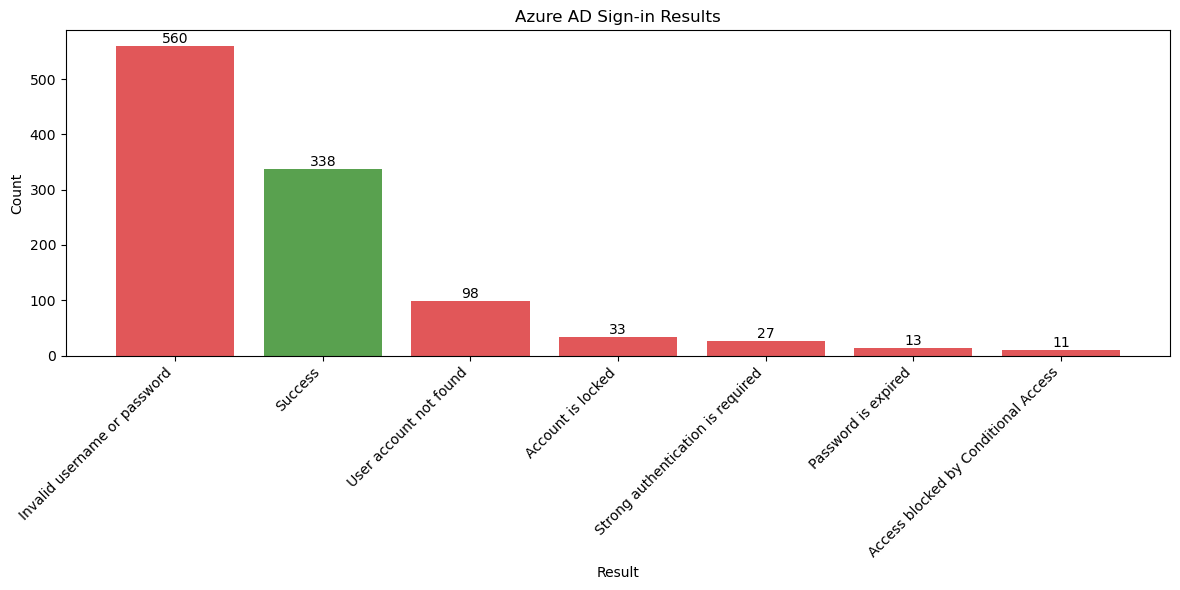

In [41]:
# Visualize sign-in results
pd_signin = signin_results.toPandas()

fig, ax = plt.subplots(figsize=(12, 6))
colors = ["#59a14f" if rt == "0" else "#e15759" for rt in pd_signin["ResultType"]]
bars = ax.bar(pd_signin["ResultDescription"], pd_signin["Count"], color=colors)
ax.bar_label(bars)
ax.set_xlabel("Result")
ax.set_ylabel("Count")
ax.set_title("Azure AD Sign-in Results")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [42]:
# Risky sign-ins
risky_signins = (
    df_signin_logs
    .filter(col("RiskLevelDuringSignIn").isin(["medium", "high"]))
    .groupBy("UserPrincipalName", "IPAddress", "Location", "RiskLevelDuringSignIn")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
    .limit(15)
)

print("Risky Sign-ins Detected:")
risky_signins.show(truncate=False)

StatementMeta(MSGMedium, 3, 43, Finished, Available, Finished)

Risky Sign-ins Detected:
+----------------------+---------------+-----------------+---------------------+-----+
|UserPrincipalName     |IPAddress      |Location         |RiskLevelDuringSignIn|Count|
+----------------------+---------------+-----------------+---------------------+-----+
|admin@contoso.com     |192.0.2.175    |Beijing, CN      |medium               |2    |
|admin@contoso.com     |192.0.2.49     |Beijing, CN      |high                 |2    |
|admin@contoso.com     |192.0.2.235    |Tehran, IR       |high                 |2    |
|jane.smith@contoso.com|192.0.2.185    |Moscow, RU       |high                 |2    |
|helpdesk@contoso.com  |203.0.113.62   |Moscow, RU       |high                 |2    |
|admin@contoso.com     |198.51.100.131 |Moscow, RU       |high                 |2    |
|jane.smith@contoso.com|203.0.113.25   |Tehran, IR       |high                 |2    |
|admin@contoso.com     |198.51.100.185 |Tehran, IR       |high                 |1    |
|ceo@contoso.com  

In [43]:
# Sign-ins by location — success vs failure
signin_by_location = (
    df_signin_logs
    .groupBy("Location")
    .agg(
        count("*").alias("Total"),
        count(when(col("ResultType") == "0", True)).alias("Success"),
        count(when(col("ResultType") != "0", True)).alias("Failed")
    )
    .orderBy(desc("Total"))
)

signin_by_location.show(truncate=False)

StatementMeta(MSGMedium, 2, 22, Finished, Available, Finished)

+-----------------+-----+-------+------+
|Location         |Total|Success|Failed|
+-----------------+-----+-------+------+
|Moscow, RU       |73   |26     |47    |
|Tehran, IR       |72   |34     |38    |
|Beijing, CN      |71   |33     |38    |
|Bangalore, IN    |71   |27     |44    |
|São Paulo, BR    |57   |26     |31    |
|Pyongyang, KP    |55   |28     |27    |
|Seattle, US      |30   |0      |30    |
|San Francisco, US|29   |2      |27    |
|Toronto, CA      |26   |2      |24    |
|London, GB       |25   |2      |23    |
|New York, US     |24   |1      |23    |
|Tokyo, JP        |23   |1      |22    |
|Berlin, DE       |22   |0      |22    |
|Sydney, AU       |22   |3      |19    |
+-----------------+-----+-------+------+



StatementMeta(MSGMedium, 3, 21, Finished, Available, Finished)

+-----------------+-----+-------+------+
|Location         |Total|Success|Failed|
+-----------------+-----+-------+------+
|Moscow, RU       |134  |50     |84    |
|Tehran, IR       |126  |54     |72    |
|Beijing, CN      |122  |60     |62    |
|Bangalore, IN    |117  |49     |68    |
|Pyongyang, KP    |111  |55     |56    |
|São Paulo, BR    |106  |48     |58    |
|Seattle, US      |49   |2      |47    |
|New York, US     |47   |2      |45    |
|Toronto, CA      |47   |4      |43    |
|Sydney, AU       |46   |4      |42    |
|Tokyo, JP        |45   |3      |42    |
|Berlin, DE       |44   |1      |43    |
|San Francisco, US|44   |3      |41    |
|London, GB       |42   |3      |39    |
+-----------------+-----+-------+------+



StatementMeta(MSGMedium, 3, 44, Finished, Available, Finished)

+-----------------+-----+-------+------+
|Location         |Total|Success|Failed|
+-----------------+-----+-------+------+
|Moscow, RU       |134  |50     |84    |
|Tehran, IR       |126  |54     |72    |
|Beijing, CN      |122  |60     |62    |
|Bangalore, IN    |117  |49     |68    |
|Pyongyang, KP    |111  |55     |56    |
|São Paulo, BR    |106  |48     |58    |
|Seattle, US      |49   |2      |47    |
|New York, US     |47   |2      |45    |
|Toronto, CA      |47   |4      |43    |
|Sydney, AU       |46   |4      |42    |
|Tokyo, JP        |45   |3      |42    |
|Berlin, DE       |44   |1      |43    |
|San Francisco, US|44   |3      |41    |
|London, GB       |42   |3      |39    |
+-----------------+-----+-------+------+



StatementMeta(MSGMedium, 3, 45, Finished, Available, Finished)

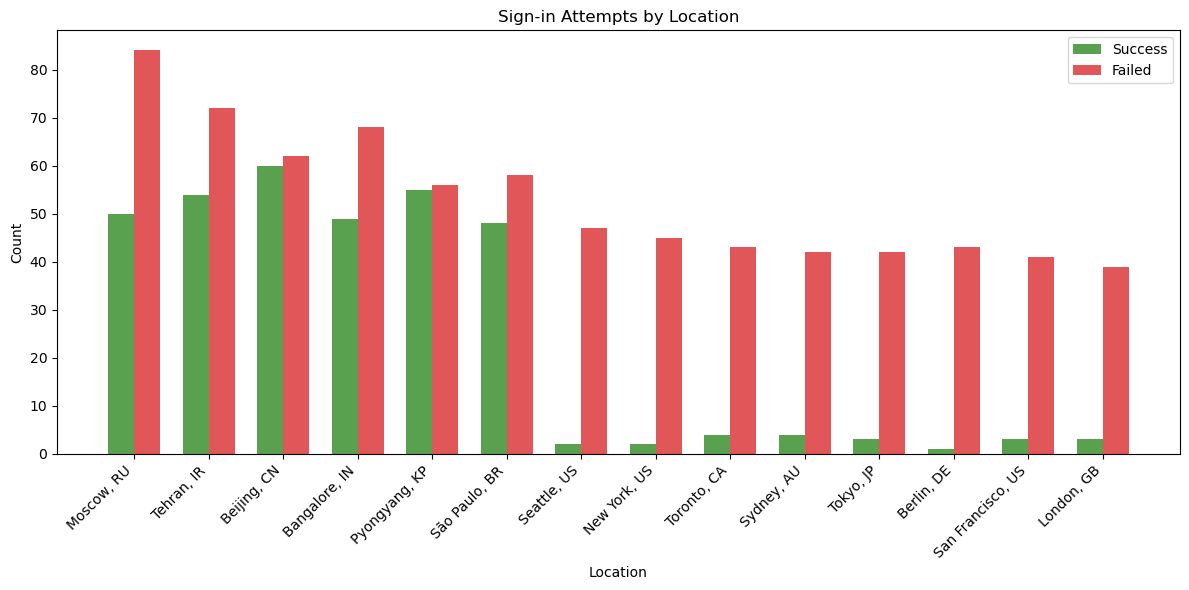

In [44]:
# Visualize sign-ins by location
pd_location = signin_by_location.toPandas()

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(pd_location))
width = 0.35
ax.bar([i - width/2 for i in x], pd_location["Success"], width, label="Success", color="#59a14f")
ax.bar([i + width/2 for i in x], pd_location["Failed"], width, label="Failed", color="#e15759")
ax.set_xlabel("Location")
ax.set_ylabel("Count")
ax.set_title("Sign-in Attempts by Location")
ax.set_xticks(x)
ax.set_xticklabels(pd_location["Location"], rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()

## 6. SyslogDemo_CL Analysis

Linux syslog events including SSH authentication, sudo abuse, and service failures.

In [45]:
# Syslog by facility and severity
syslog_overview = (
    df_syslog
    .groupBy("Facility", "SeverityLevel")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
)

syslog_overview.show(truncate=False)

StatementMeta(MSGMedium, 2, 24, Finished, Available, Finished)

+--------+-------------+-----+
|Facility|SeverityLevel|Count|
+--------+-------------+-----+
|auth    |warning      |126  |
|authpriv|info         |100  |
|auth    |err          |34   |
|daemon  |err          |31   |
|daemon  |crit         |29   |
+--------+-------------+-----+



StatementMeta(MSGMedium, 3, 23, Finished, Available, Finished)

+--------+-------------+-----+
|Facility|SeverityLevel|Count|
+--------+-------------+-----+
|auth    |warning      |366  |
|authpriv|info         |300  |
|auth    |err          |114  |
|daemon  |crit         |94   |
|daemon  |err          |86   |
+--------+-------------+-----+



StatementMeta(MSGMedium, 3, 46, Finished, Available, Finished)

+--------+-------------+-----+
|Facility|SeverityLevel|Count|
+--------+-------------+-----+
|auth    |warning      |366  |
|authpriv|info         |300  |
|auth    |err          |114  |
|daemon  |crit         |94   |
|daemon  |err          |86   |
+--------+-------------+-----+



StatementMeta(MSGMedium, 2, 25, Finished, Available, Finished)

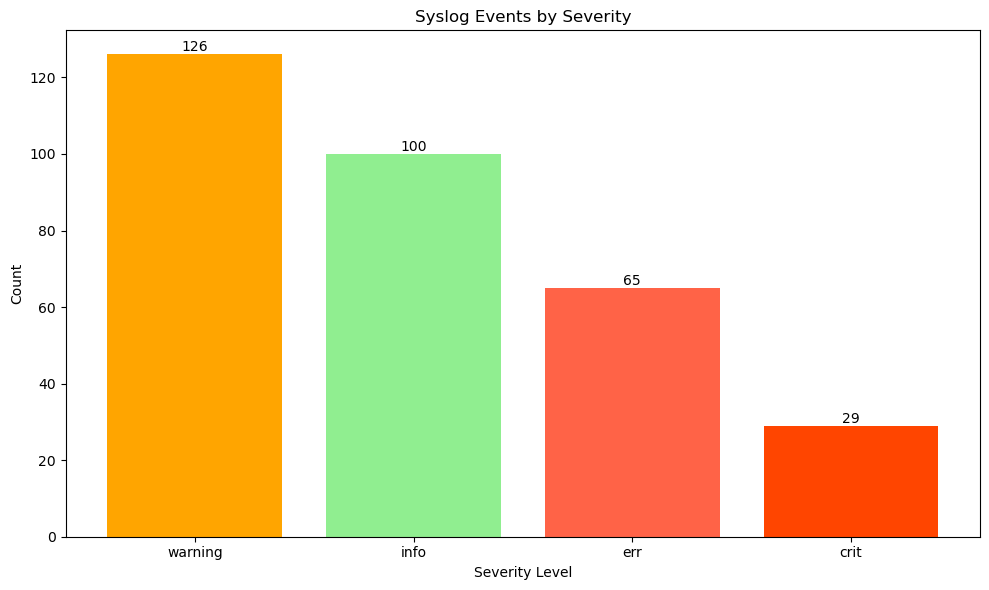

StatementMeta(MSGMedium, 3, 24, Finished, Available, Finished)

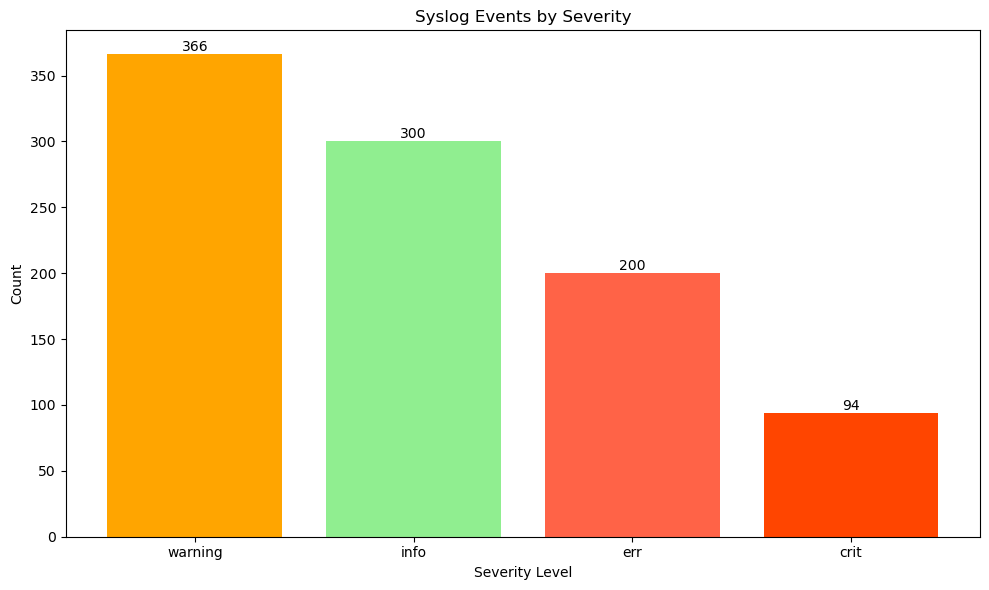

StatementMeta(MSGMedium, 3, 47, Finished, Available, Finished)

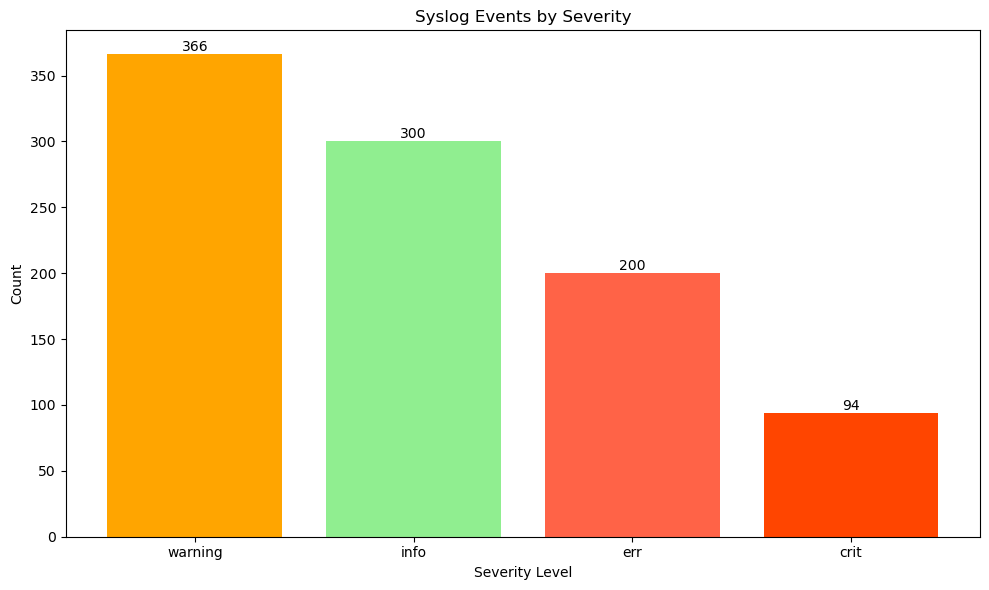

In [46]:
# Visualize syslog severity distribution
pd_syslog = syslog_overview.toPandas()
syslog_by_severity = pd_syslog.groupby("SeverityLevel")["Count"].sum().sort_values(ascending=False)

severity_colors = {
    "emerg": "#8B0000", "alert": "#FF0000", "crit": "#FF4500",
    "err": "#FF6347", "warning": "#FFA500", "notice": "#FFD700",
    "info": "#90EE90", "debug": "#ADD8E6"
}
colors = [severity_colors.get(s, "#CCCCCC") for s in syslog_by_severity.index]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(syslog_by_severity.index, syslog_by_severity.values, color=colors)
ax.bar_label(bars)
ax.set_xlabel("Severity Level")
ax.set_ylabel("Count")
ax.set_title("Syslog Events by Severity")
plt.tight_layout()
plt.show()

In [47]:
# SSH authentication failures
ssh_failures = (
    df_syslog
    .filter(
        (col("ProcessName") == "sshd") &
        (col("SyslogMessage").contains("Failed"))
    )
    .groupBy("Computer", "HostIP")
    .agg(count("*").alias("FailedAttempts"))
    .filter(col("FailedAttempts") >= 3)
    .orderBy(desc("FailedAttempts"))
    .limit(15)
)

print("SSH Brute Force Targets (3+ failures):")
ssh_failures.show(truncate=False)

StatementMeta(MSGMedium, 3, 48, Finished, Available, Finished)

SSH Brute Force Targets (3+ failures):
+---------------------------+---------+--------------+
|Computer                   |HostIP   |FailedAttempts|
+---------------------------+---------+--------------+
|db-replica.contoso.local   |10.1.2.11|26            |
|jump-server.contoso.local  |10.1.7.10|25            |
|k8s-master.contoso.local   |10.1.8.10|23            |
|mail-server.contoso.local  |10.1.4.10|23            |
|proxy-server.contoso.local |10.1.6.10|22            |
|web-server-02.contoso.local|10.1.1.11|20            |
|k8s-worker-01.contoso.local|10.1.8.11|20            |
|app-server-01.contoso.local|10.1.3.10|20            |
|db-primary.contoso.local   |10.1.2.10|18            |
|web-server-01.contoso.local|10.1.1.10|18            |
|dns-server.contoso.local   |10.1.5.10|17            |
|app-server-02.contoso.local|10.1.3.11|14            |
+---------------------------+---------+--------------+



In [48]:
# Service failures
service_failures = (
    df_syslog
    .filter(
        (col("Facility") == "daemon") &
        (col("SeverityLevel").isin(["err", "crit"]))
    )
    .groupBy("Computer", "ProcessName", "SeverityLevel")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
    .limit(15)
)

print("Service Failures:")
service_failures.show(truncate=False)

StatementMeta(MSGMedium, 3, 49, Finished, Available, Finished)

Service Failures:
+---------------------------+-----------+-------------+-----+
|Computer                   |ProcessName|SeverityLevel|Count|
+---------------------------+-----------+-------------+-----+
|k8s-worker-01.contoso.local|systemd    |crit         |20   |
|db-primary.contoso.local   |systemd    |err          |13   |
|web-server-02.contoso.local|systemd    |crit         |11   |
|k8s-worker-01.contoso.local|systemd    |err          |10   |
|jump-server.contoso.local  |systemd    |crit         |9    |
|web-server-01.contoso.local|systemd    |err          |9    |
|proxy-server.contoso.local |systemd    |crit         |8    |
|app-server-02.contoso.local|systemd    |crit         |8    |
|mail-server.contoso.local  |systemd    |err          |8    |
|proxy-server.contoso.local |systemd    |err          |7    |
|k8s-master.contoso.local   |systemd    |err          |7    |
|db-replica.contoso.local   |systemd    |err          |7    |
|k8s-master.contoso.local   |systemd    |crit       

## 7. Alerts & Incidents Analysis

Alerts and incidents generated by the **[Demo]** analytic rules from the Sentinel Data Generator.
These are sourced from the `SecurityAlert` and `SecurityIncident` tables and correlate to
events in the four demo tables analyzed above.

In [49]:
# Load SecurityAlert and SecurityIncident tables
df_alerts = data_provider.read_table("SecurityAlert", WORKSPACE_NAME)
df_incidents = data_provider.read_table("SecurityIncident", WORKSPACE_NAME)

# Filter to only [Demo] analytic rules
df_demo_alerts = df_alerts.filter(col("AlertName").startswith("[Demo]"))
df_demo_incidents = df_incidents.filter(col("Title").startswith("[Demo]"))

alert_count = df_demo_alerts.count()
incident_count = df_demo_incidents.count()

print(f"[Demo] Alerts loaded: {alert_count:,}")
print(f"[Demo] Incidents loaded: {incident_count:,}")

StatementMeta(MSGMedium, 3, 50, Finished, Available, Finished)

{"Level": "INFO", "TraceId": "c73d69e9-4bae-41ac-be0a-5217ab37d8f5", "Message": "Loading table: SecurityAlert"}
{"Level": "INFO", "TraceId": "c73d69e9-4bae-41ac-be0a-5217ab37d8f5", "Message": "Successfully loaded table SecurityAlert"}
{"Level": "INFO", "TraceId": "c73d69e9-4bae-41ac-be0a-5217ab37d8f5", "Message": "Loading table: SecurityIncident"}
{"Level": "INFO", "TraceId": "c73d69e9-4bae-41ac-be0a-5217ab37d8f5", "Message": "Successfully loaded table SecurityIncident"}
[Demo] Alerts loaded: 258
[Demo] Incidents loaded: 184


In [50]:
# Alerts by rule name and severity
alerts_by_rule = (
    df_demo_alerts
    .groupBy("AlertName", "AlertSeverity")
    .agg(count("*").alias("AlertCount"))
    .orderBy(desc("AlertCount"))
)

print("Alerts by Analytic Rule:")
alerts_by_rule.show(truncate=False)

StatementMeta(MSGMedium, 3, 51, Finished, Available, Finished)

Alerts by Analytic Rule:
+-----------------------------------------------------------------+-------------+----------+
|AlertName                                                        |AlertSeverity|AlertCount|
+-----------------------------------------------------------------+-------------+----------+
|[Demo] Windows Brute Force Attack Detected                       |High         |52        |
|[Demo] Azure AD Brute Force Attack                               |High         |52        |
|[Demo] SSH Brute Force Attack on Linux                           |High         |40        |
|[Demo] Privilege Escalation - New Account with Special Privileges|High         |32        |
|[Demo] Threat Intelligence IOC Match                             |High         |28        |
|[Demo] Critical Service Failure Detected                         |Medium       |27        |
|[Demo] Sign-in from Risky Location                               |Medium       |27        |
+--------------------------------------------

StatementMeta(MSGMedium, 3, 52, Finished, Available, Finished)

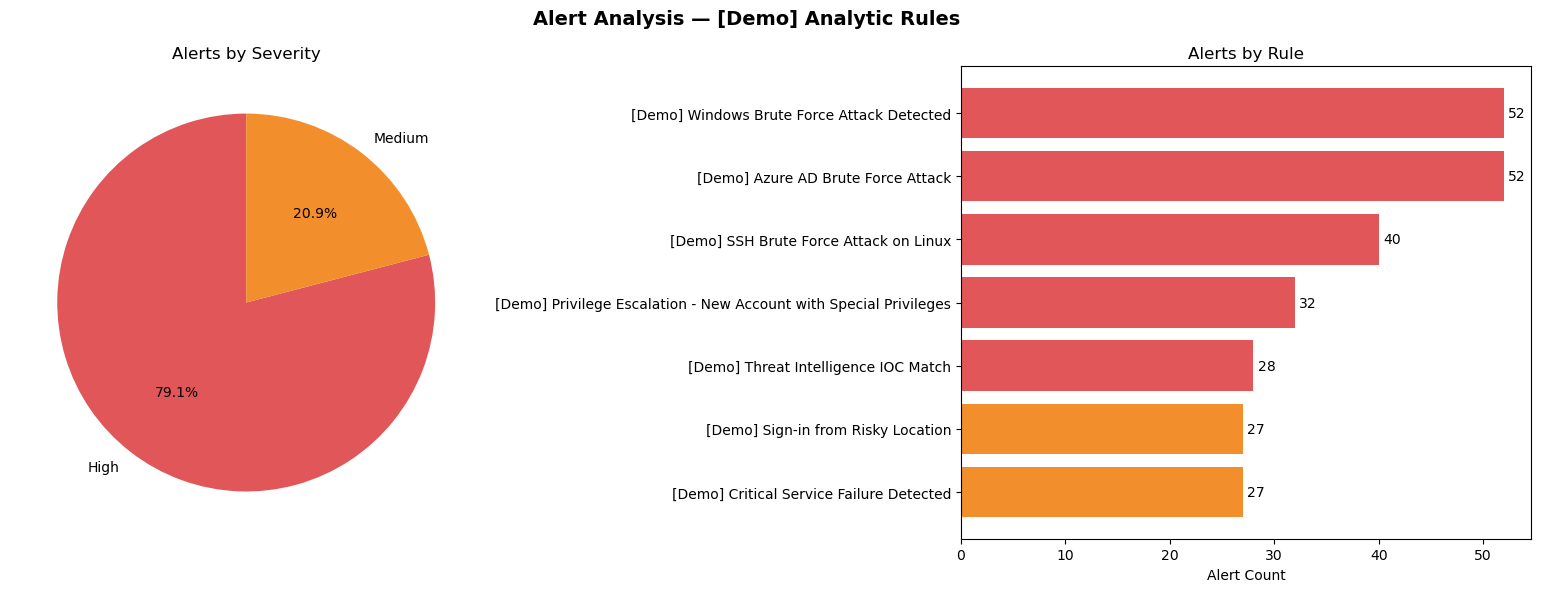

In [51]:
# Visualize alerts by severity (pie) and by rule (horizontal bar)
pd_alerts_by_rule = alerts_by_rule.toPandas()

severity_order = ["High", "Medium", "Low", "Informational"]
severity_colors_map = {
    "High": "#e15759", "Medium": "#f28e2b",
    "Low": "#edc949", "Informational": "#76b7b2"
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Alert Analysis — [Demo] Analytic Rules", fontsize=14, fontweight="bold")

# Pie: alerts by severity
sev_totals = pd_alerts_by_rule.groupby("AlertSeverity")["AlertCount"].sum()
sev_totals = sev_totals.reindex([s for s in severity_order if s in sev_totals.index])
colors = [severity_colors_map.get(s, "#CCCCCC") for s in sev_totals.index]
axes[0].pie(sev_totals.values, labels=sev_totals.index, autopct="%1.1f%%",
            startangle=90, colors=colors)
axes[0].set_title("Alerts by Severity")

# Horizontal bar: alerts by rule
rule_totals = pd_alerts_by_rule.groupby("AlertName")["AlertCount"].sum().sort_values()
bar_colors = []
for rule in rule_totals.index:
    sev = pd_alerts_by_rule.loc[pd_alerts_by_rule["AlertName"] == rule, "AlertSeverity"].iloc[0]
    bar_colors.append(severity_colors_map.get(sev, "#CCCCCC"))
bars = axes[1].barh(rule_totals.index, rule_totals.values, color=bar_colors)
axes[1].bar_label(bars, padding=3)
axes[1].set_xlabel("Alert Count")
axes[1].set_title("Alerts by Rule")

plt.tight_layout()
plt.show()

StatementMeta(MSGMedium, 3, 53, Finished, Available, Finished)

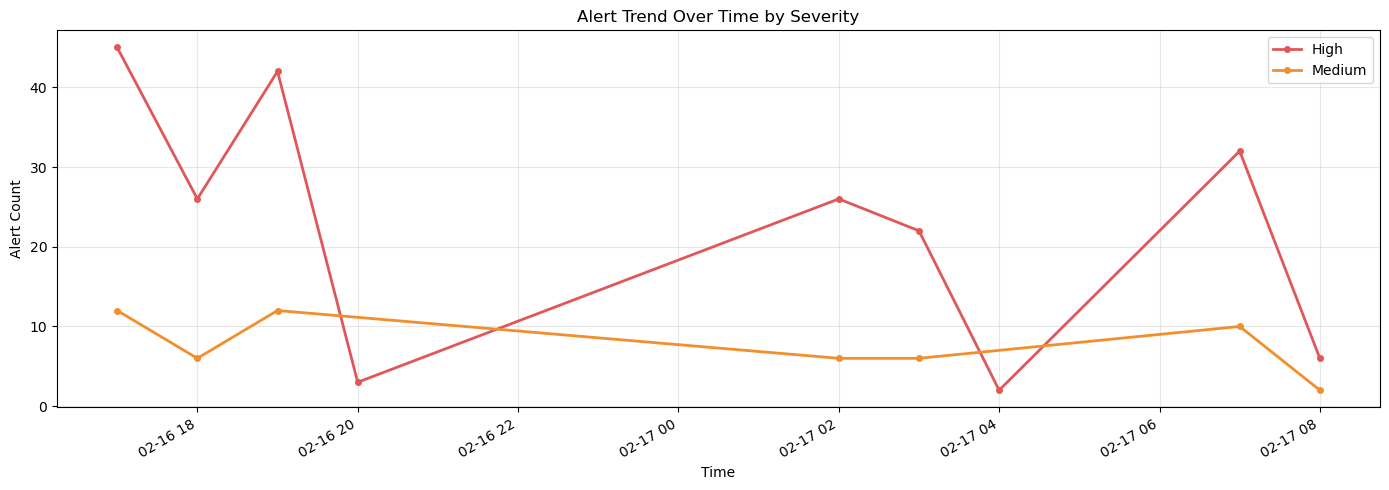

In [52]:
from pyspark.sql.functions import date_trunc, to_timestamp, min as spark_min, max as spark_max

# Alerts over time — trend line by severity
alerts_over_time = (
    df_demo_alerts
    .withColumn("TimeBin", date_trunc("hour", col("TimeGenerated")))
    .groupBy("TimeBin", "AlertSeverity")
    .agg(count("*").alias("Count"))
    .orderBy("TimeBin")
)

pd_alerts_time = alerts_over_time.toPandas()

fig, ax = plt.subplots(figsize=(14, 5))
for sev in severity_order:
    subset = pd_alerts_time[pd_alerts_time["AlertSeverity"] == sev]
    if not subset.empty:
        ax.plot(subset["TimeBin"], subset["Count"],
                label=sev, color=severity_colors_map.get(sev, "#CCCCCC"),
                marker="o", markersize=4, linewidth=2)

ax.set_xlabel("Time")
ax.set_ylabel("Alert Count")
ax.set_title("Alert Trend Over Time by Severity")
ax.legend()
ax.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [53]:
# Recent alerts detail table
recent_alerts = (
    df_demo_alerts
    .select("TimeGenerated", "AlertName", "AlertSeverity", "Description")
    .orderBy(desc("TimeGenerated"))
    .limit(25)
)

print("25 Most Recent [Demo] Alerts:")
recent_alerts.show(truncate=False)

StatementMeta(MSGMedium, 3, 54, Finished, Available, Finished)

25 Most Recent [Demo] Alerts:
+--------------------------+-----------------------------------------------------------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TimeGenerated [UTC]       |AlertName                                                        |AlertSeverity|Description                                                                                                                                                                  |
+--------------------------+-----------------------------------------------------------------+-------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|2026-02-17 08:58:57.244298|[Demo] Privilege Escalation - New Account with Special Privileges|High         |Detects when 

### Incidents

Incidents created from the [Demo] analytic rules, grouped by severity, status, and trending over time.

In [54]:
# Incidents by severity and status
incidents_by_severity = (
    df_demo_incidents
    .groupBy("Severity")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
)

incidents_by_status = (
    df_demo_incidents
    .groupBy("Status")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
)

print("Incidents by Severity:")
incidents_by_severity.show(truncate=False)

print("Incidents by Status:")
incidents_by_status.show(truncate=False)

StatementMeta(MSGMedium, 3, 55, Finished, Available, Finished)

Incidents by Severity:
+--------+-----+
|Severity|Count|
+--------+-----+
|High    |145  |
|Medium  |39   |
+--------+-----+

Incidents by Status:
+------+-----+
|Status|Count|
+------+-----+
|New   |146  |
|Closed|38   |
+------+-----+



StatementMeta(MSGMedium, 3, 56, Finished, Available, Finished)

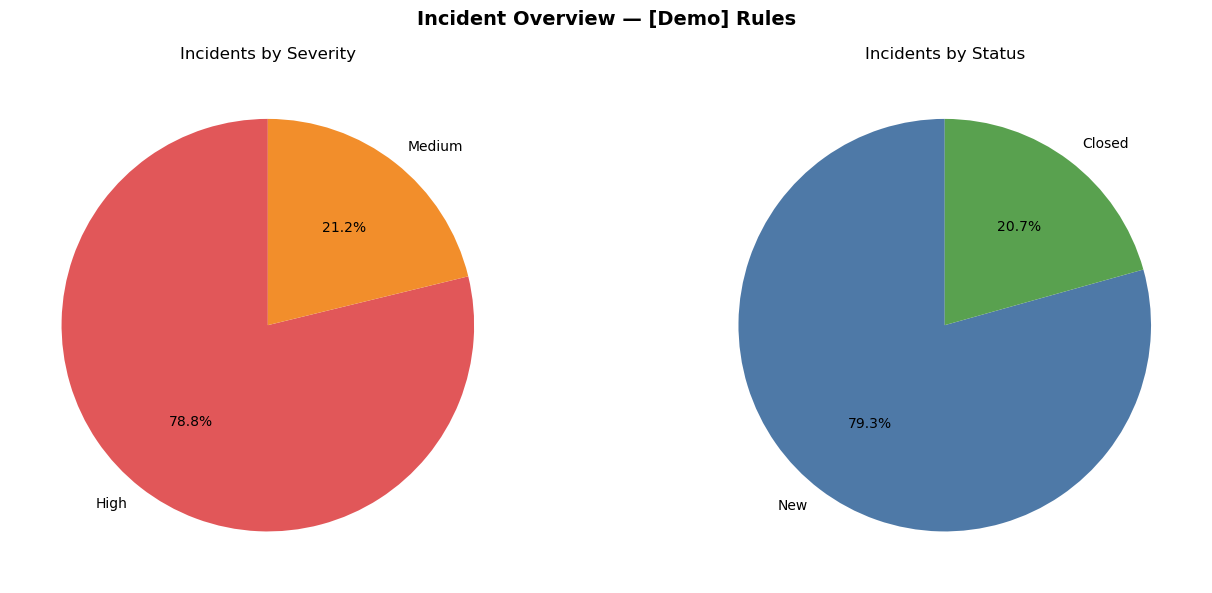

In [55]:
# Visualize incidents: severity pie + status pie
pd_inc_sev = incidents_by_severity.toPandas()
pd_inc_status = incidents_by_status.toPandas()

status_colors_map = {
    "New": "#4e79a7", "Active": "#f28e2b",
    "Closed": "#59a14f", "Resolved": "#76b7b2"
}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Incident Overview — [Demo] Rules", fontsize=14, fontweight="bold")

# Severity pie
if not pd_inc_sev.empty:
    sev_colors = [severity_colors_map.get(s, "#CCCCCC") for s in pd_inc_sev["Severity"]]
    axes[0].pie(pd_inc_sev["Count"], labels=pd_inc_sev["Severity"],
                autopct="%1.1f%%", startangle=90, colors=sev_colors)
    axes[0].set_title("Incidents by Severity")
else:
    axes[0].text(0.5, 0.5, "No incidents", ha="center", va="center")

# Status pie
if not pd_inc_status.empty:
    stat_colors = [status_colors_map.get(s, "#CCCCCC") for s in pd_inc_status["Status"]]
    axes[1].pie(pd_inc_status["Count"], labels=pd_inc_status["Status"],
                autopct="%1.1f%%", startangle=90, colors=stat_colors)
    axes[1].set_title("Incidents by Status")
else:
    axes[1].text(0.5, 0.5, "No incidents", ha="center", va="center")

plt.tight_layout()
plt.show()

StatementMeta(MSGMedium, 3, 57, Finished, Available, Finished)

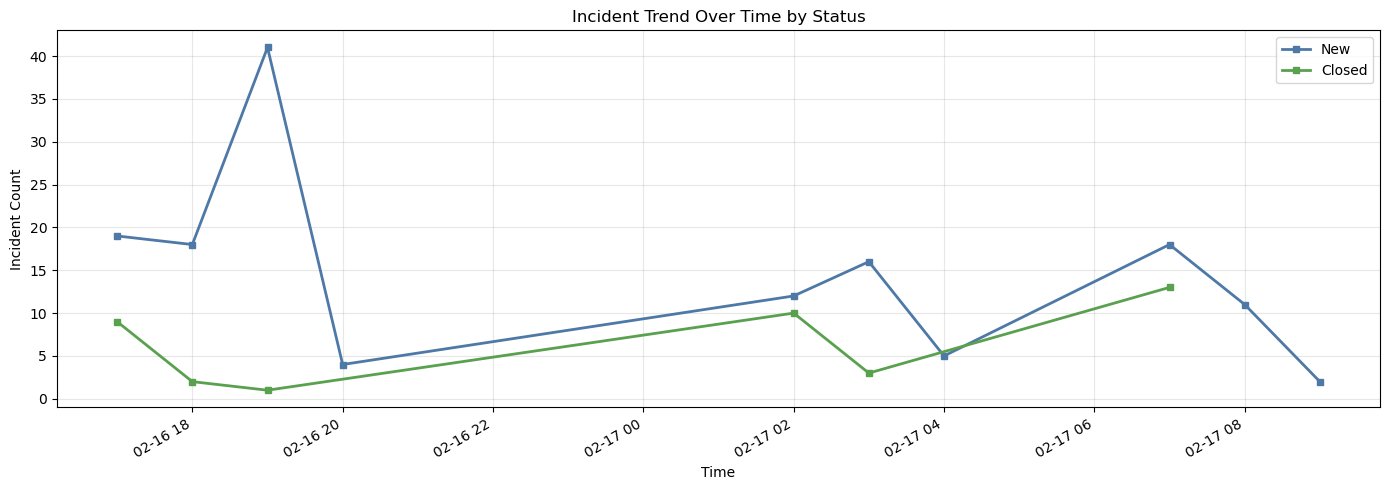

In [56]:
# Incidents over time — trend line by status
incidents_over_time = (
    df_demo_incidents
    .withColumn("TimeBin", date_trunc("hour", col("TimeGenerated")))
    .groupBy("TimeBin", "Status")
    .agg(count("*").alias("Count"))
    .orderBy("TimeBin")
)

pd_inc_time = incidents_over_time.toPandas()

fig, ax = plt.subplots(figsize=(14, 5))
for status in pd_inc_time["Status"].unique():
    subset = pd_inc_time[pd_inc_time["Status"] == status]
    color = status_colors_map.get(status, "#CCCCCC")
    ax.plot(subset["TimeBin"], subset["Count"],
            label=status, color=color, marker="s", markersize=4, linewidth=2)

ax.set_xlabel("Time")
ax.set_ylabel("Incident Count")
ax.set_title("Incident Trend Over Time by Status")
ax.legend()
ax.grid(True, alpha=0.3)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [57]:
# Recent incidents detail table
from pyspark.sql.functions import get_json_object

recent_incidents = (
    df_demo_incidents
    .select("TimeGenerated", "Title", "Severity", "Status")
    .orderBy(desc("TimeGenerated"))
    .limit(25)
)

print("25 Most Recent [Demo] Incidents:")
recent_incidents.show(truncate=False)

StatementMeta(MSGMedium, 3, 58, Finished, Available, Finished)

25 Most Recent [Demo] Incidents:
+--------------------------+-----------------------------------------------------------------+--------+------+
|TimeGenerated [UTC]       |Title                                                            |Severity|Status|
+--------------------------+-----------------------------------------------------------------+--------+------+
|2026-02-17 09:04:17.641964|[Demo] Privilege Escalation - New Account with Special Privileges|High    |New   |
|2026-02-17 09:01:12.373333|[Demo] Privilege Escalation - New Account with Special Privileges|High    |New   |
|2026-02-17 08:46:18.58171 |[Demo] Privilege Escalation - New Account with Special Privileges|High    |New   |
|2026-02-17 08:44:12.78    |[Demo] Privilege Escalation - New Account with Special Privileges|High    |New   |
|2026-02-17 08:31:17.316412|[Demo] Privilege Escalation - New Account with Special Privileges|High    |New   |
|2026-02-17 08:29:51.573333|[Demo] Privilege Escalation - New Account with Spec

### Alerts & Incidents Combined Dashboard

Combined view correlating alerts and incidents from the four demo source tables.

In [58]:
from pyspark.sql.functions import explode, from_json, schema_of_json, array

# Most targeted entities from alert data
# Entities column is a JSON array string — parse and explode
entity_analysis = (
    df_demo_alerts
    .filter(col("Entities").isNotNull() & (col("Entities") != "[]"))
    .selectExpr("SystemAlertId", "explode(from_json(Entities, 'array<struct<Type:string,Name:string,Address:string,HostName:string>>')) as Entity")
    .filter(col("Entity.Type").isin(["account", "ip", "host"]))
    .selectExpr(
        "SystemAlertId",
        "Entity.Type as EntityType",
        "coalesce(Entity.Name, Entity.Address, Entity.HostName) as EntityName"
    )
    .filter(col("EntityName").isNotNull())
    .groupBy("EntityName", "EntityType")
    .agg(countDistinct("SystemAlertId").alias("AlertCount"))
    .orderBy(desc("AlertCount"))
    .limit(15)
)

print("Most Targeted Entities Across [Demo] Alerts:")
entity_analysis.show(truncate=False)

StatementMeta(MSGMedium, 3, 59, Finished, Available, Finished)

Most Targeted Entities Across [Demo] Alerts:
+-----------------------+----------+----------+
|EntityName             |EntityType|AlertCount|
+-----------------------+----------+----------+
|203.0.113.50           |ip        |89        |
|contractor@partner.com |account   |79        |
|admin@contoso.com      |account   |79        |
|developer@contoso.com  |account   |78        |
|helpdesk@contoso.com   |account   |76        |
|test.user@contoso.com  |account   |76        |
|svc-backup@contoso.com |account   |76        |
|jane.smith@contoso.com |account   |75        |
|guest_user@external.com|account   |67        |
|john.doe@contoso.com   |account   |66        |
|DC01.contoso.com       |host      |52        |
|ceo@contoso.com        |account   |51        |
|10.1.2.11              |ip        |39        |
|203.0.113.51           |ip        |34        |
|10.1.6.10              |ip        |33        |
+-----------------------+----------+----------+



StatementMeta(MSGMedium, 3, 60, Finished, Available, Finished)

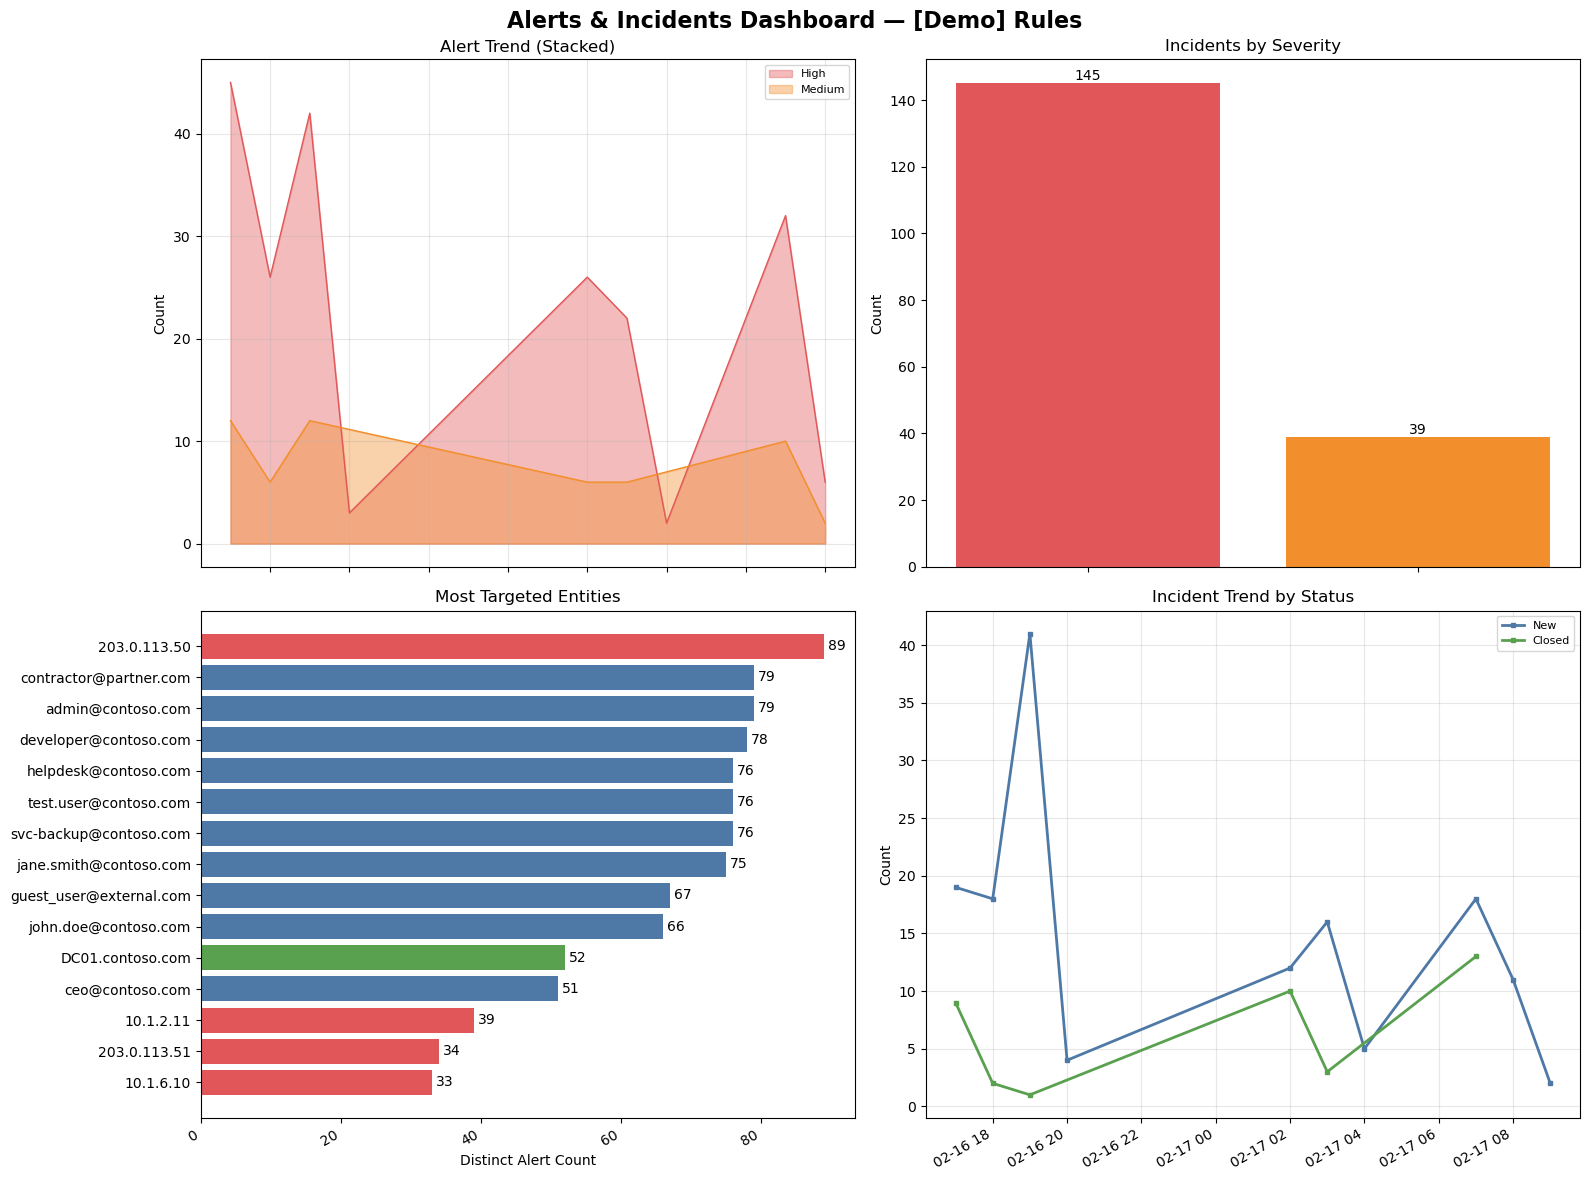

In [59]:
# Combined Alerts & Incidents dashboard (2x2)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Alerts & Incidents Dashboard — [Demo] Rules", fontsize=16, fontweight="bold")

# Plot 1: Alert trend over time (stacked area)
ax = axes[0, 0]
if not pd_alerts_time.empty:
    for sev in severity_order:
        subset = pd_alerts_time[pd_alerts_time["AlertSeverity"] == sev]
        if not subset.empty:
            ax.fill_between(subset["TimeBin"], subset["Count"], alpha=0.4,
                            color=severity_colors_map.get(sev, "#CCCCCC"), label=sev)
            ax.plot(subset["TimeBin"], subset["Count"],
                    color=severity_colors_map.get(sev, "#CCCCCC"), linewidth=1)
    ax.legend(fontsize=8)
ax.set_title("Alert Trend (Stacked)")
ax.set_ylabel("Count")
ax.grid(True, alpha=0.3)
fig.autofmt_xdate()

# Plot 2: Incident severity (bar)
ax = axes[0, 1]
if not pd_inc_sev.empty:
    sev_c = [severity_colors_map.get(s, "#CCCCCC") for s in pd_inc_sev["Severity"]]
    bars = ax.bar(pd_inc_sev["Severity"], pd_inc_sev["Count"], color=sev_c)
    ax.bar_label(bars)
ax.set_title("Incidents by Severity")
ax.set_ylabel("Count")

# Plot 3: Targeted entities (horizontal bar)
ax = axes[1, 0]
pd_entities = entity_analysis.toPandas()
if not pd_entities.empty:
    entity_colors = {"account": "#4e79a7", "ip": "#e15759", "host": "#59a14f"}
    ent_c = [entity_colors.get(t, "#CCCCCC") for t in pd_entities["EntityType"]]
    bars = ax.barh(pd_entities["EntityName"], pd_entities["AlertCount"], color=ent_c)
    ax.bar_label(bars, padding=3)
    ax.invert_yaxis()
ax.set_title("Most Targeted Entities")
ax.set_xlabel("Distinct Alert Count")

# Plot 4: Incident trend over time
ax = axes[1, 1]
if not pd_inc_time.empty:
    for status in pd_inc_time["Status"].unique():
        subset = pd_inc_time[pd_inc_time["Status"] == status]
        color = status_colors_map.get(status, "#CCCCCC")
        ax.plot(subset["TimeBin"], subset["Count"],
                label=status, color=color, marker="s", markersize=3, linewidth=2)
    ax.legend(fontsize=8)
ax.set_title("Incident Trend by Status")
ax.set_ylabel("Count")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Security Summary Dashboard

StatementMeta(MSGMedium, 3, 61, Finished, Available, Finished)

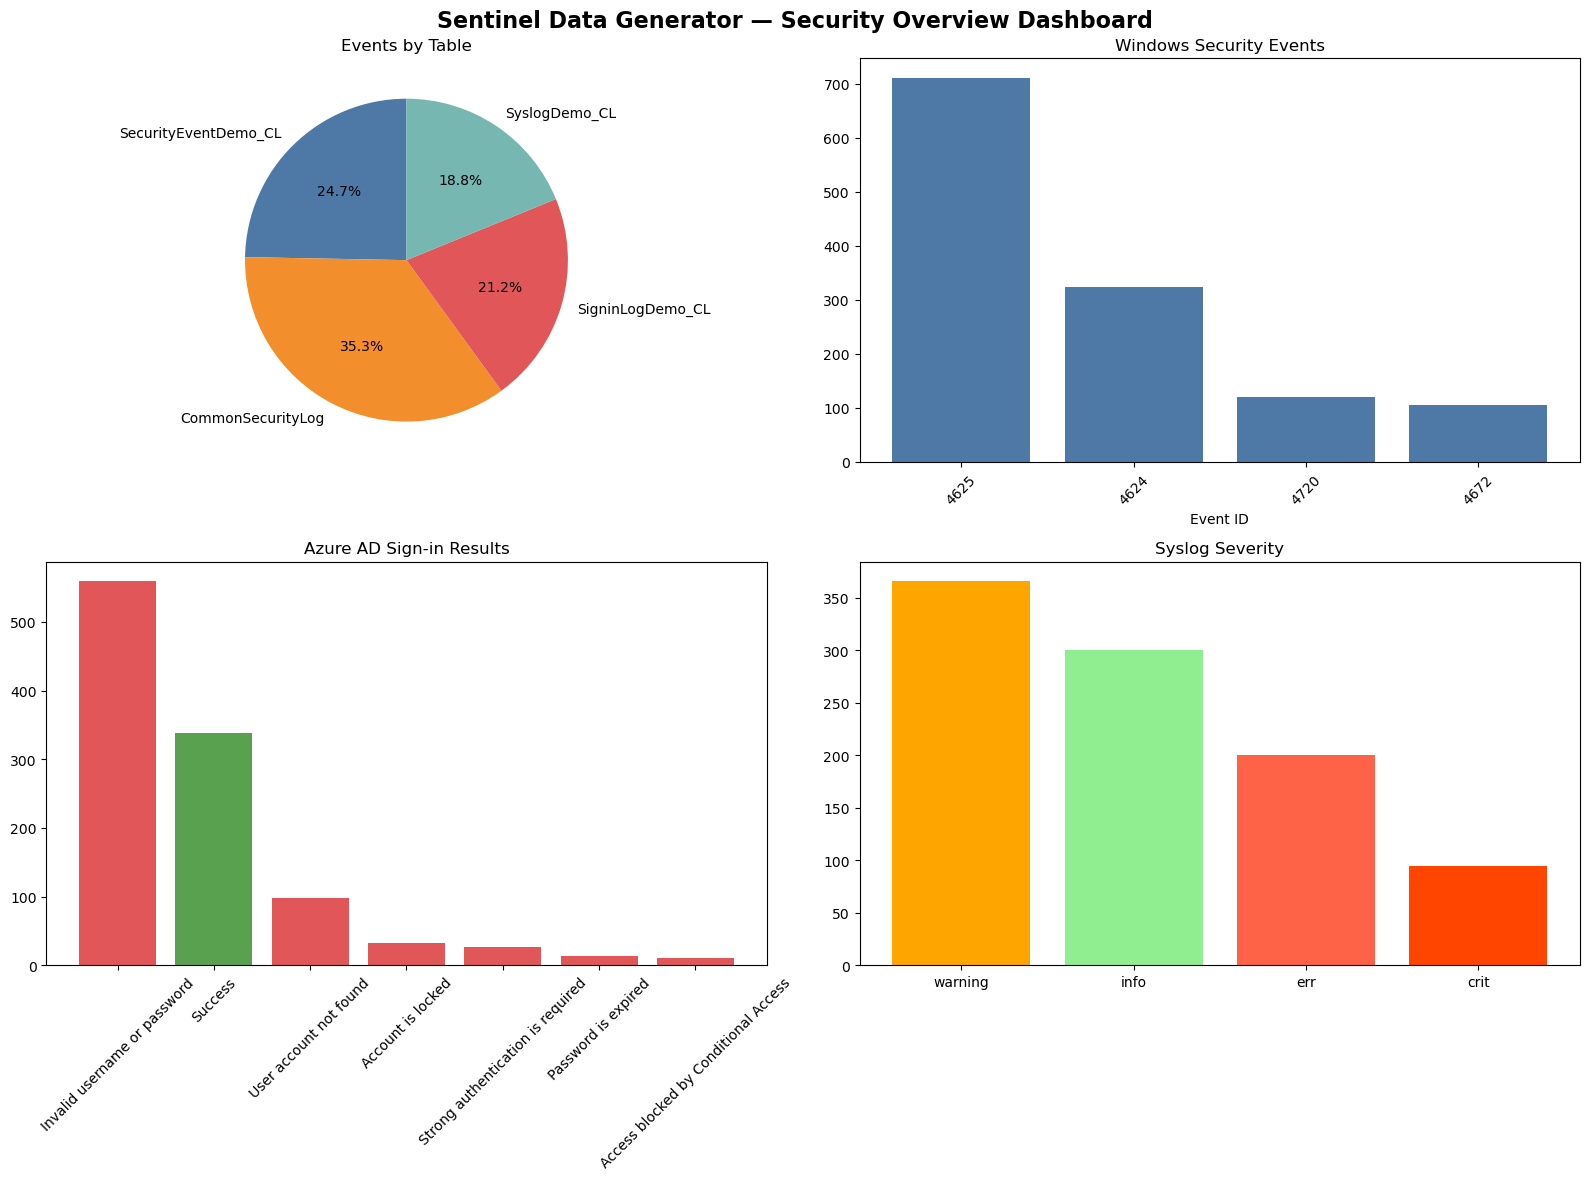

In [60]:
# Create a 2x2 summary dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Sentinel Data Generator — Security Overview Dashboard", fontsize=16, fontweight="bold")

# Plot 1: Events by table (pie)
axes[0, 0].pie(
    counts.values(),
    labels=counts.keys(),
    autopct="%1.1f%%",
    startangle=90,
    colors=["#4e79a7", "#f28e2b", "#e15759", "#76b7b2"]
)
axes[0, 0].set_title("Events by Table")

# Plot 2: Security events by EventID (bar)
axes[0, 1].bar(pd_security["EventID"].astype(str), pd_security["Count"], color="#4e79a7")
axes[0, 1].set_title("Windows Security Events")
axes[0, 1].set_xlabel("Event ID")
axes[0, 1].tick_params(axis="x", rotation=45)

# Plot 3: Sign-in results (bar)
signin_colors = ["#59a14f" if rt == "0" else "#e15759" for rt in pd_signin["ResultType"]]
axes[1, 0].bar(pd_signin["ResultDescription"], pd_signin["Count"], color=signin_colors)
axes[1, 0].set_title("Azure AD Sign-in Results")
axes[1, 0].tick_params(axis="x", rotation=45)

# Plot 4: Syslog severity (bar)
sev_colors = [severity_colors.get(s, "#CCCCCC") for s in syslog_by_severity.index]
axes[1, 1].bar(syslog_by_severity.index, syslog_by_severity.values, color=sev_colors)
axes[1, 1].set_title("Syslog Severity")

plt.tight_layout()
plt.show()

## 9. Key Findings Summary

In [61]:
# Collect summary counts from Spark DataFrames
failed_4625_count = df_security_events.filter(col("EventID") == 4625).count()
brute_force_sources = failed_logins.count()

success_signin_count = df_signin_logs.filter(col("ResultType") == "0").count()
failed_signin_count = df_signin_logs.filter(col("ResultType") != "0").count()
risky_count = risky_signins.count()

threat_count = threats.count()
firewall_count = firewall_denies.count()

ssh_target_count = ssh_failures.count()
service_failure_count = service_failures.count()

print("=" * 60)
print("SECURITY ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nTotal Events Analyzed: {total:,}")
print(f"\nWindows Security:")
print(f"  - Failed Logons (4625): {failed_4625_count:,}")
print(f"  - Potential Brute Force Sources: {brute_force_sources}")
print(f"\nAzure AD Sign-ins:")
print(f"  - Successful: {success_signin_count:,}")
print(f"  - Failed: {failed_signin_count:,}")
print(f"  - Risky Sign-ins: {risky_count}")
print(f"\nNetwork Security (CommonSecurityLog):")
print(f"  - Threat Detections: {threat_count}")
print(f"  - Firewall Blocks: {firewall_count}")
print(f"\nLinux Systems (Syslog):")
print(f"  - SSH Attack Targets: {ssh_target_count}")
print(f"  - Service Failures: {service_failure_count}")
print(f"\nAlerts & Incidents ([Demo] Rules):")
print(f"  - Total Alerts: {alert_count:,}")
print(f"  - Total Incidents: {incident_count:,}")
print("\n" + "=" * 60)

StatementMeta(MSGMedium, 3, 28, Finished, Available, Finished)

SECURITY ANALYSIS SUMMARY

Total Events Analyzed: 5,101

Windows Security:
  - Failed Logons (4625): 711
  - Potential Brute Force Sources: 1

Azure AD Sign-ins:
  - Successful: 338
  - Failed: 742
  - Risky Sign-ins: 15

Network Security (CommonSecurityLog):
  - Threat Detections: 15
  - Firewall Blocks: 0

Linux Systems (Syslog):
  - SSH Attack Targets: 12
  - Service Failures: 15

Alerts & Incidents ([Demo] Rules):


NameError: name 'alert_count' is not defined

StatementMeta(MSGMedium, 3, 62, Finished, Available, Finished)

SECURITY ANALYSIS SUMMARY

Total Events Analyzed: 5,101

Windows Security:
  - Failed Logons (4625): 711
  - Potential Brute Force Sources: 1

Azure AD Sign-ins:
  - Successful: 338
  - Failed: 742
  - Risky Sign-ins: 15

Network Security (CommonSecurityLog):
  - Threat Detections: 15
  - Firewall Blocks: 0

Linux Systems (Syslog):
  - SSH Attack Targets: 12
  - Service Failures: 15

Alerts & Incidents ([Demo] Rules):
  - Total Alerts: 258
  - Total Incidents: 184

